# Семантическая сегментация ResNet+Unet

## Импорт библиотек

In [1]:
!pip install matplotlib
!pip install opencv-python
!pip install scikit-learn
!pip install torchvision
!pip install segmentation-models-pytorch
!pip install torchinfo

In [2]:
from pathlib import Path
import matplotlib.pyplot as plt
import cv2
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from PIL import Image
import os

import torch
from torch.utils.data import Dataset, DataLoader
from torch import nn, optim

from torchvision import transforms
from torchinfo import summary


from tqdm.auto import tqdm
import warnings
warnings.filterwarnings("ignore")

import segmentation_models_pytorch as smp

/home/user/Projects/semantic_seg/venv/lib/python3.12/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


## Подготовка датасета

In [3]:
IMAGE_PATH = Path("city_dataset/augment_500/image")
IMAGE_PATH_LIST = list(IMAGE_PATH.glob("*.png"))
IMAGE_PATH_LIST = sorted(IMAGE_PATH_LIST)

print(f"Всего изображений = {len(IMAGE_PATH_LIST)}")

Всего изображений = 500


In [4]:
MASK_PATH = Path("city_dataset/augment_500/mask")
MASK_PATH_LIST = list(MASK_PATH.glob("*.png"))
MASK_PATH_LIST = sorted(MASK_PATH_LIST)

print(f"Всего масок = {len(MASK_PATH_LIST)}")

Всего масок = 500


Проверка данных

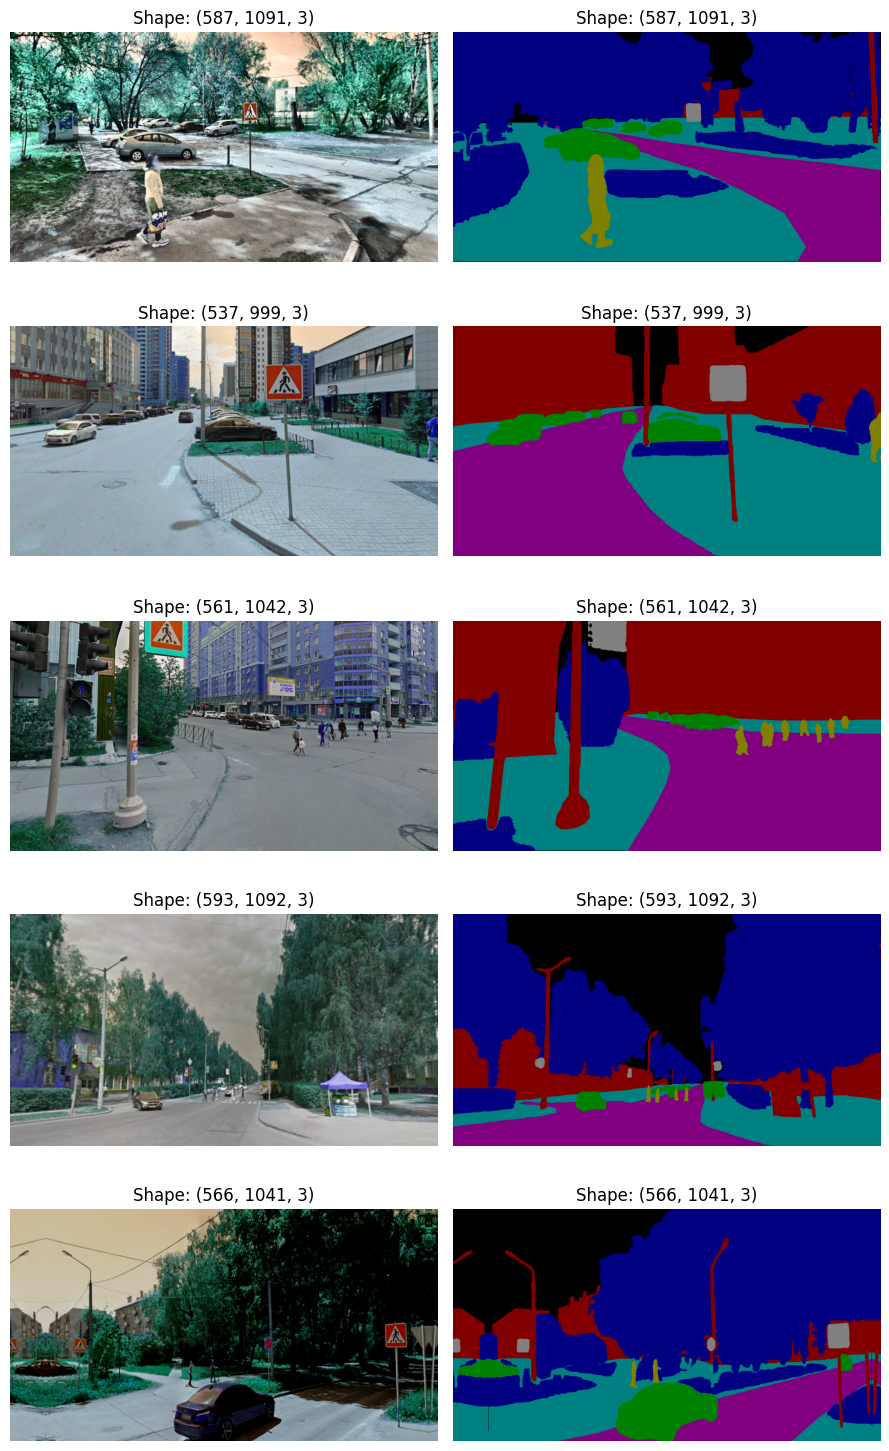

In [5]:
fig,ax = plt.subplots(nrows = 5, ncols = 2, figsize = (9,15))

for i,(img_path, mk_path) in enumerate(zip(IMAGE_PATH_LIST, MASK_PATH_LIST)):
    if i > 4:
        break
        
    img_bgr = cv2.imread(str(img_path))
    img_rgb = cv2.cvtColor(img_bgr, cv2.COLOR_BGR2RGB)
    ax[i,0].imshow(img_bgr)
    ax[i,0].axis('off')
    ax[i,0].set_title(f'Shape: {img_rgb.shape}')
    
    mask_bgr = cv2.imread(str(mk_path))
    mask_rgb = cv2.cvtColor(mask_bgr, cv2.COLOR_BGR2RGB)
    ax[i,1].imshow(mask_rgb)
    ax[i,1].axis('off')
    ax[i,1].set_title(f'Shape: {mask_rgb.shape}')

fig.tight_layout()
fig.show()

Проверка путей файлов

In [6]:
images_paths = [None] * len(IMAGE_PATH_LIST)
masks_paths = [None] * len(MASK_PATH_LIST)

for i,(img_path, mask_path) in enumerate(zip(IMAGE_PATH_LIST, MASK_PATH_LIST)):
    images_paths[i] = img_path
    masks_paths[i] = mask_path
    
data = pd.DataFrame({'Image':images_paths, 'Mask':masks_paths})
data.head()

,Image,Mask
0,city_dataset/augment_500/image/img_001.png,city_dataset/augment_500/mask/label_001.png
1,city_dataset/augment_500/image/img_002.png,city_dataset/augment_500/mask/label_002.png
2,city_dataset/augment_500/image/img_003.png,city_dataset/augment_500/mask/label_003.png
3,city_dataset/augment_500/image/img_004.png,city_dataset/augment_500/mask/label_004.png
4,city_dataset/augment_500/image/img_005.png,city_dataset/augment_500/mask/label_005.png


Разделяем данные на обучающую, валидационную и тестовую выборку

In [7]:
SEED = 42

data_train, data_rest = train_test_split(data, test_size = 0.3, random_state = SEED)
data_val, data_test = train_test_split(data_rest, test_size = 0.5, random_state = SEED)

Определяем классы и их RGB коды

In [8]:
color2id = {
    (0, 0, 0):0,       # background  
    (128, 0, 128):1,   # road
    (0, 128, 128):2,   # side
    (128, 0, 0):3,     # builds
    (0, 0, 128):4,     # plant
    (0, 128, 0):5,     # car
    (128, 128, 0):6,   # human
    (128,128,128):7    # sign
}

Функция для преобразования цветных масок в числовые метки

In [9]:
def mapping_color(img:Image, color2id:dict):
    image = np.array(img)
    
    height,width,_ = image.shape
    output_matrix = np.full(shape = (height, width), fill_value = -1, dtype = np.int32)
    
    for h in range(height):
        for w in range(width):
            color_pixel = tuple(image[h,w,:])
            
            if color_pixel in color2id:
                output_matrix[h,w] = color2id[color_pixel]
            
    return output_matrix

Создадим класс для загрузки изображений и масок

In [10]:
class CustomDataset(Dataset):
    def __init__(self, data:pd.DataFrame, color2id:dict, image_transforms, mask_transforms):
        self.data = data
        self.color2id = color2id
        self.image_transforms = image_transforms
        self.mask_transforms = mask_transforms
        
    def __len__(self):
        return len(self.data)
    
    def __getitem__(self, idx):      
        image_path = data.iloc[idx, 0]
        image = Image.open(image_path).convert("RGB")
        image = self.image_transforms(image)
        
        mask_path = data.iloc[idx, 1]
        mask = Image.open(mask_path).convert("RGB")
        mask = self.mask_transforms(mask)
        mask = mapping_color(mask, self.color2id)
    
        return image, mask

Делаем ресайз масок и изображений

In [11]:
RESIZE = (512, 512)

image_transforms = transforms.Compose([transforms.Resize(RESIZE), transforms.ToTensor()])
mask_transforms = transforms.Compose([transforms.Resize(RESIZE)])

Определяем тренировачный и валидационный датасет

In [12]:
train_dataset = CustomDataset(data_train, 
                              color2id, 
                              image_transforms, 
                              mask_transforms)

val_dataset = CustomDataset(data_val, 
                            color2id, 
                            image_transforms, 
                            mask_transforms)

Создаем DataLoader'ы для загрузки данных в модель во время обучения и валидации. Опеределяем размер батча. 


5 примерно 4 GiB

10 примерно 5 GiB

50 примерно 19-20 GiB

In [13]:
BATCH_SIZE = 10
NUM_WORKERS = os.cpu_count()

train_dataloader = DataLoader(dataset = train_dataset, 
                              batch_size = BATCH_SIZE, 
                              shuffle = True, 
                              num_workers = NUM_WORKERS)

val_dataloader = DataLoader(dataset = val_dataset, 
                            batch_size = 1, 
                            shuffle = False, 
                            num_workers = NUM_WORKERS)

Проверяем данные

In [14]:
batch_images, batch_masks = next(iter(train_dataloader))
batch_images.shape, batch_masks.shape

(torch.Size([10, 3, 512, 512]), torch.Size([10, 512, 512]))

## Подготовка девайса и модели

Определяем девайс

In [15]:
DEVICE = "cuda" if torch.cuda.is_available() else "cpu"
DEVICE

'cuda'

Определяем модель Unet с ResNet50 в качестве энкодера

In [16]:
model = smp.Unet(encoder_name="resnet50", classes = 8)

Сводка о модели

In [17]:
summary(model = model, 
        col_width = 17, 
        input_size = [1,3,512,512],
        col_names = ['input_size','output_size','num_params','trainable'], 
        row_settings = ['var_names'])

Layer (type (var_name))                            Input Shape       Output Shape      Param #           Trainable
Unet (Unet)                                        [1, 3, 512, 512]  [1, 8, 512, 512]  --                True
├─ResNetEncoder (encoder)                          [1, 3, 512, 512]  [1, 3, 512, 512]  --                True
│    └─Conv2d (conv1)                              [1, 3, 512, 512]  [1, 64, 256, 256] 9,408             True
│    └─BatchNorm2d (bn1)                           [1, 64, 256, 256] [1, 64, 256, 256] 128               True
│    └─ReLU (relu)                                 [1, 64, 256, 256] [1, 64, 256, 256] --                --
│    └─MaxPool2d (maxpool)                         [1, 64, 256, 256] [1, 64, 128, 128] --                --
│    └─Sequential (layer1)                         [1, 64, 128, 128] [1, 256, 128, 128] --                True
│    │    └─Bottleneck (0)                         [1, 64, 128, 128] [1, 256, 128, 128] 75,008            True
│    │ 

Отключаем обновление градиентов для параметров кодировщика модели U-Net чтобы заморозить веса кодировщика и обучать только декодер

In [18]:
for param in model.encoder.parameters():
    param.requires_grad = False

In [19]:
summary(model = model, 
        col_width = 17, 
        input_size = [1,3,512,512],
        col_names = ['input_size','output_size','num_params','trainable'], 
        row_settings = ['var_names'])

Layer (type (var_name))                            Input Shape       Output Shape      Param #           Trainable
Unet (Unet)                                        [1, 3, 512, 512]  [1, 8, 512, 512]  --                Partial
├─ResNetEncoder (encoder)                          [1, 3, 512, 512]  [1, 3, 512, 512]  --                False
│    └─Conv2d (conv1)                              [1, 3, 512, 512]  [1, 64, 256, 256] (9,408)           False
│    └─BatchNorm2d (bn1)                           [1, 64, 256, 256] [1, 64, 256, 256] (128)             False
│    └─ReLU (relu)                                 [1, 64, 256, 256] [1, 64, 256, 256] --                --
│    └─MaxPool2d (maxpool)                         [1, 64, 256, 256] [1, 64, 128, 128] --                --
│    └─Sequential (layer1)                         [1, 64, 128, 128] [1, 256, 128, 128] --                False
│    │    └─Bottleneck (0)                         [1, 64, 128, 128] [1, 256, 128, 128] (75,008)          False

## Подготовка к обучению

Инициализируем функцию потерь и оптимизатор для обучения модели

In [20]:
loss_fn = smp.losses.DiceLoss(mode = "multiclass", classes = 8, ignore_index = -1)
optimizer = optim.Adam(model.parameters(), lr = 0.01, weight_decay = 0.0001)

Определяем класс для предотвращения переобучения модели путем отслеживания val loss

In [21]:
class EarlyStopping:
    def __init__(self, patience:int = 5, delta:float = 0.0001, path = "best_model.pth"):
        self.patience = patience
        self.delta = delta
        self.path = path
        self.best_score = None
        self.counter = 0
        self.early_stop = False
        
    def __call__(self, val_loss, model):
        if self.best_score is None:
            self.best_score = val_loss
            self.save_checkpoint(model)
            
        elif val_loss > self.best_score + self.delta:
            self.counter += 1
            if self.counter >= self.patience:
                self.early_stop = True
                
        else:
            self.best_score = val_loss
            self.save_checkpoint(model)
            self.counter = 0
            
    def save_checkpoint(self, model):
        torch.save(model.state_dict(), self.path)

Определим 12 эпох как период в течении которого модель будет продолжать после последнего улучшения val loss, прежде чем остановиться.
    
Любое улучшение val loss (даже самое минимальное) будет считаться значимым улучшением

In [22]:
early_stopping = EarlyStopping(patience = 20, delta = 0.)

Определяем функции обучения и валидации

In [23]:
def train_step(model:torch.nn.Module, dataloader:torch.utils.data.DataLoader, 
               loss_fn:smp.losses, optimizer:torch.optim.Optimizer):
    
    model.train()
    
    train_loss = 0.
    train_iou = 0.
    
    for batch,(X,y) in enumerate(dataloader):
        X = X.to(device = DEVICE, dtype = torch.float32)
        y = y.to(device = DEVICE, dtype = torch.long)
        
        optimizer.zero_grad()
        
        pred_logit = model(X)
        loss = loss_fn(pred_logit, y)
        train_loss = loss.item()
        
        loss.backward()
        optimizer.step()
        
        pred_prob = pred_logit.softmax(dim = 1)
        pred_class = pred_prob.argmax(dim = 1)
        
        tp,fp,fn,tn = smp.metrics.get_stats(output = pred_class.detach().cpu().long(), 
                                            target = y.cpu(), 
                                            mode = "multiclass", 
                                            ignore_index = -1, 
                                            num_classes = 8)
        
        train_iou += smp.metrics.iou_score(tp, fp, fn, tn, reduction = "micro")
        
    train_loss = train_loss / len(dataloader)
    train_iou = train_iou / len(dataloader)
    
    return train_loss, train_iou

In [24]:
def val_step(model:torch.nn.Module, dataloader:torch.utils.data.DataLoader, 
             loss_fn:smp.losses):
    
    model.eval()
    
    val_loss = 0.
    val_iou = 0.
    
    with torch.inference_mode():
    
        for batch,(X,y) in enumerate(dataloader):
            X = X.to(device = DEVICE, dtype = torch.float32)
            y = y.to(device = DEVICE, dtype = torch.long)

            pred_logit = model(X)
            loss = loss_fn(pred_logit, y)
            val_loss = loss.item()

            pred_prob = pred_logit.softmax(dim = 1)
            pred_class = pred_prob.argmax(dim = 1)

            tp,fp,fn,tn = smp.metrics.get_stats(output = pred_class.detach().cpu().long(), 
                                                target = y.cpu(), 
                                                mode = "multiclass", 
                                                ignore_index = -1, 
                                                num_classes = 8)

            val_iou += smp.metrics.iou_score(tp, fp, fn, tn, reduction = "micro")
        
        
    val_loss = val_loss / len(dataloader)
    val_iou = val_iou / len(dataloader)
    
    return val_loss, val_iou

In [25]:
def train(model:torch.nn.Module, train_dataloader:torch.utils.data.DataLoader, 
          val_dataloader:torch.utils.data.DataLoader, loss_fn:torch.nn.Module, optimizer:torch.optim.Optimizer, 
          early_stopping, epochs:int = 10):
    
    results = {'train_loss':[], 'train_iou':[], 'val_loss':[], 'val_iou':[]}
    
    for epoch in tqdm(range(epochs)):
        train_loss, train_iou = train_step(model = model, 
                                           dataloader = train_dataloader, 
                                           loss_fn = loss_fn, 
                                           optimizer = optimizer)
        
        val_loss, val_iou = val_step(model = model, 
                                     dataloader = val_dataloader, 
                                     loss_fn = loss_fn)
        
        print(f'Epoch: {epoch + 1} | ', 
              f'Train Loss: {train_loss:.4f} | ', 
              f'Train IOU: {train_iou:.4f} | ', 
              f'Val Loss: {val_loss:.4f} | ', 
              f'Val IOU: {val_iou:.4f}')
        
        
        early_stopping(val_loss, model)
        
        if early_stopping.early_stop == True:
            print("Early Stopping!!")
            break
            
        results['train_loss'].append(train_loss)
        results['train_iou'].append(train_iou)
        results['val_loss'].append(val_loss)
        results['val_iou'].append(val_iou)
        
    return results

## Обучение модели

Определяем количество эпох, включим все необходимые компоненты и запускаем обучение

In [26]:
EPOCHS = 100

torch.cuda.manual_seed(SEED)
torch.manual_seed(SEED)

RESULTS = train(model.to(device = DEVICE), 
                train_dataloader, 
                val_dataloader, 
                loss_fn, 
                optimizer, 
                early_stopping, 
                EPOCHS)


  0%|                                                                                                                                                                                                 | 0/100 [00:00<?, ?it/s]

Epoch: 1 |  Train Loss: 0.0124 |  Train IOU: 0.6067 |  Val Loss: 0.0044 |  Val IOU: 0.7000


  1%|█▊                                                                                                                                                                                       | 1/100 [00:23<38:14, 23.17s/it]

Epoch: 2 |  Train Loss: 0.0079 |  Train IOU: 0.6783 |  Val Loss: 0.0043 |  Val IOU: 0.6988


  3%|█████▌                                                                                                                                                                                   | 3/100 [01:10<37:52, 23.42s/it]

Epoch: 3 |  Train Loss: 0.0059 |  Train IOU: 0.7022 |  Val Loss: 0.0056 |  Val IOU: 0.6408


  4%|███████▍                                                                                                                                                                                 | 4/100 [01:33<37:17, 23.30s/it]

Epoch: 4 |  Train Loss: 0.0062 |  Train IOU: 0.7223 |  Val Loss: 0.0054 |  Val IOU: 0.7249


  5%|█████████▎                                                                                                                                                                               | 5/100 [01:57<37:09, 23.47s/it]

Epoch: 5 |  Train Loss: 0.0050 |  Train IOU: 0.7208 |  Val Loss: 0.0051 |  Val IOU: 0.6976
Epoch: 6 |  Train Loss: 0.0044 |  Train IOU: 0.7352 |  Val Loss: 0.0034 |  Val IOU: 0.7019


  6%|███████████                                                                                                                                                                              | 6/100 [02:21<37:09, 23.72s/it]

Epoch: 7 |  Train Loss: 0.0045 |  Train IOU: 0.7482 |  Val Loss: 0.0030 |  Val IOU: 0.7504


  8%|██████████████▊                                                                                                                                                                          | 8/100 [03:08<36:18, 23.68s/it]

Epoch: 8 |  Train Loss: 0.0040 |  Train IOU: 0.7539 |  Val Loss: 0.0035 |  Val IOU: 0.7736
Epoch: 9 |  Train Loss: 0.0058 |  Train IOU: 0.7729 |  Val Loss: 0.0029 |  Val IOU: 0.7234


 10%|██████████████████▍                                                                                                                                                                     | 10/100 [03:57<35:51, 23.90s/it]

Epoch: 10 |  Train Loss: 0.0041 |  Train IOU: 0.7744 |  Val Loss: 0.0029 |  Val IOU: 0.7611


 11%|████████████████████▏                                                                                                                                                                   | 11/100 [04:22<36:02, 24.29s/it]

Epoch: 11 |  Train Loss: 0.0048 |  Train IOU: 0.7736 |  Val Loss: 0.0041 |  Val IOU: 0.7258
Epoch: 12 |  Train Loss: 0.0036 |  Train IOU: 0.7866 |  Val Loss: 0.0023 |  Val IOU: 0.8014


 13%|███████████████████████▉                                                                                                                                                                | 13/100 [05:10<35:01, 24.16s/it]

Epoch: 13 |  Train Loss: 0.0031 |  Train IOU: 0.7936 |  Val Loss: 0.0029 |  Val IOU: 0.7667


 14%|█████████████████████████▊                                                                                                                                                              | 14/100 [05:34<34:27, 24.04s/it]

Epoch: 14 |  Train Loss: 0.0047 |  Train IOU: 0.7850 |  Val Loss: 0.0028 |  Val IOU: 0.7885


 15%|███████████████████████████▌                                                                                                                                                            | 15/100 [05:58<34:05, 24.07s/it]

Epoch: 15 |  Train Loss: 0.0040 |  Train IOU: 0.7861 |  Val Loss: 0.0037 |  Val IOU: 0.7674


 16%|█████████████████████████████▍                                                                                                                                                          | 16/100 [06:22<33:37, 24.02s/it]

Epoch: 16 |  Train Loss: 0.0035 |  Train IOU: 0.7897 |  Val Loss: 0.0033 |  Val IOU: 0.7488


 17%|███████████████████████████████▎                                                                                                                                                        | 17/100 [06:46<33:10, 23.98s/it]

Epoch: 17 |  Train Loss: 0.0040 |  Train IOU: 0.7978 |  Val Loss: 0.0028 |  Val IOU: 0.8087


 18%|█████████████████████████████████                                                                                                                                                       | 18/100 [07:12<33:32, 24.55s/it]

Epoch: 18 |  Train Loss: 0.0031 |  Train IOU: 0.7919 |  Val Loss: 0.0026 |  Val IOU: 0.8078


 19%|██████████████████████████████████▉                                                                                                                                                     | 19/100 [07:37<33:25, 24.76s/it]

Epoch: 19 |  Train Loss: 0.0039 |  Train IOU: 0.7886 |  Val Loss: 0.0032 |  Val IOU: 0.7326


 20%|████████████████████████████████████▊                                                                                                                                                   | 20/100 [08:01<32:44, 24.56s/it]

Epoch: 20 |  Train Loss: 0.0033 |  Train IOU: 0.7903 |  Val Loss: 0.0036 |  Val IOU: 0.7365


 21%|██████████████████████████████████████▋                                                                                                                                                 | 21/100 [08:25<32:01, 24.32s/it]

Epoch: 21 |  Train Loss: 0.0040 |  Train IOU: 0.7961 |  Val Loss: 0.0026 |  Val IOU: 0.7988


 22%|████████████████████████████████████████▍                                                                                                                                               | 22/100 [08:49<31:31, 24.26s/it]

Epoch: 22 |  Train Loss: 0.0032 |  Train IOU: 0.7973 |  Val Loss: 0.0026 |  Val IOU: 0.7896
Epoch: 23 |  Train Loss: 0.0032 |  Train IOU: 0.7940 |  Val Loss: 0.0018 |  Val IOU: 0.8283


 23%|██████████████████████████████████████████▎                                                                                                                                             | 23/100 [09:14<31:14, 24.34s/it]

Epoch: 24 |  Train Loss: 0.0040 |  Train IOU: 0.8053 |  Val Loss: 0.0017 |  Val IOU: 0.8014


 25%|██████████████████████████████████████████████                                                                                                                                          | 25/100 [10:02<30:13, 24.18s/it]

Epoch: 25 |  Train Loss: 0.0046 |  Train IOU: 0.7964 |  Val Loss: 0.0024 |  Val IOU: 0.8132


 26%|███████████████████████████████████████████████▊                                                                                                                                        | 26/100 [10:28<30:26, 24.68s/it]

Epoch: 26 |  Train Loss: 0.0039 |  Train IOU: 0.8082 |  Val Loss: 0.0020 |  Val IOU: 0.7967


 27%|█████████████████████████████████████████████████▋                                                                                                                                      | 27/100 [10:52<30:02, 24.69s/it]

Epoch: 27 |  Train Loss: 0.0029 |  Train IOU: 0.8146 |  Val Loss: 0.0022 |  Val IOU: 0.7800


 28%|███████████████████████████████████████████████████▌                                                                                                                                    | 28/100 [11:16<29:25, 24.52s/it]

Epoch: 28 |  Train Loss: 0.0029 |  Train IOU: 0.8051 |  Val Loss: 0.0027 |  Val IOU: 0.7931


 29%|█████████████████████████████████████████████████████▎                                                                                                                                  | 29/100 [11:40<28:43, 24.28s/it]

Epoch: 29 |  Train Loss: 0.0030 |  Train IOU: 0.8025 |  Val Loss: 0.0025 |  Val IOU: 0.8122


 30%|███████████████████████████████████████████████████████▏                                                                                                                                | 30/100 [12:04<28:13, 24.19s/it]

Epoch: 30 |  Train Loss: 0.0039 |  Train IOU: 0.8099 |  Val Loss: 0.0030 |  Val IOU: 0.8054


 31%|█████████████████████████████████████████████████████████                                                                                                                               | 31/100 [12:29<27:59, 24.34s/it]

Epoch: 31 |  Train Loss: 0.0034 |  Train IOU: 0.8000 |  Val Loss: 0.0037 |  Val IOU: 0.7502


 32%|██████████████████████████████████████████████████████████▉                                                                                                                             | 32/100 [12:53<27:22, 24.16s/it]

Epoch: 32 |  Train Loss: 0.0037 |  Train IOU: 0.8144 |  Val Loss: 0.0023 |  Val IOU: 0.8140


 33%|████████████████████████████████████████████████████████████▋                                                                                                                           | 33/100 [13:18<27:25, 24.56s/it]

Epoch: 33 |  Train Loss: 0.0037 |  Train IOU: 0.8133 |  Val Loss: 0.0031 |  Val IOU: 0.7232


 34%|██████████████████████████████████████████████████████████████▌                                                                                                                         | 34/100 [13:42<26:43, 24.30s/it]

Epoch: 34 |  Train Loss: 0.0031 |  Train IOU: 0.8144 |  Val Loss: 0.0022 |  Val IOU: 0.8261


 35%|████████████████████████████████████████████████████████████████▍                                                                                                                       | 35/100 [14:06<26:13, 24.21s/it]

Epoch: 35 |  Train Loss: 0.0029 |  Train IOU: 0.8167 |  Val Loss: 0.0024 |  Val IOU: 0.7900


 36%|██████████████████████████████████████████████████████████████████▏                                                                                                                     | 36/100 [14:30<25:42, 24.11s/it]

Epoch: 36 |  Train Loss: 0.0030 |  Train IOU: 0.8064 |  Val Loss: 0.0021 |  Val IOU: 0.8270


 37%|████████████████████████████████████████████████████████████████████                                                                                                                    | 37/100 [14:53<25:13, 24.02s/it]

Epoch: 37 |  Train Loss: 0.0025 |  Train IOU: 0.8207 |  Val Loss: 0.0032 |  Val IOU: 0.8195


 38%|█████████████████████████████████████████████████████████████████████▉                                                                                                                  | 38/100 [15:17<24:48, 24.01s/it]

Epoch: 38 |  Train Loss: 0.0033 |  Train IOU: 0.8196 |  Val Loss: 0.0027 |  Val IOU: 0.8265


 39%|███████████████████████████████████████████████████████████████████████▊                                                                                                                | 39/100 [15:42<24:37, 24.23s/it]

Epoch: 39 |  Train Loss: 0.0026 |  Train IOU: 0.8192 |  Val Loss: 0.0022 |  Val IOU: 0.7970


 40%|█████████████████████████████████████████████████████████████████████████▌                                                                                                              | 40/100 [16:07<24:24, 24.42s/it]

Epoch: 40 |  Train Loss: 0.0034 |  Train IOU: 0.8046 |  Val Loss: 0.0018 |  Val IOU: 0.8223


 41%|███████████████████████████████████████████████████████████████████████████▍                                                                                                            | 41/100 [16:31<23:49, 24.22s/it]

Epoch: 41 |  Train Loss: 0.0031 |  Train IOU: 0.8122 |  Val Loss: 0.0026 |  Val IOU: 0.8086


 42%|█████████████████████████████████████████████████████████████████████████████▎                                                                                                          | 42/100 [16:55<23:19, 24.13s/it]

Epoch: 42 |  Train Loss: 0.0032 |  Train IOU: 0.8173 |  Val Loss: 0.0023 |  Val IOU: 0.8011


 43%|███████████████████████████████████████████████████████████████████████████████                                                                                                         | 43/100 [17:18<22:46, 23.97s/it]

Epoch: 43 |  Train Loss: 0.0036 |  Train IOU: 0.8157 |  Val Loss: 0.0018 |  Val IOU: 0.8211


 43%|███████████████████████████████████████████████████████████████████████████████                                                                                                         | 43/100 [17:43<23:29, 24.72s/it]

Epoch: 44 |  Train Loss: 0.0032 |  Train IOU: 0.8180 |  Val Loss: 0.0024 |  Val IOU: 0.8011
Early Stopping!!


Отобразим результаты обучения

In [27]:
def loss_and_metric_plot(results:dict):
    training_loss = results['train_loss']
    valid_loss = results['val_loss']
    
    training_iou = results['train_iou']
    valid_iou = results['val_iou']
    
    fig,axes = plt.subplots(nrows = 1, ncols = 2, figsize = (9,4))
    axes = axes.flat
    
    axes[0].plot(range(len(training_loss)), training_loss)
    axes[0].plot(range(len(valid_loss)), valid_loss)
    axes[0].set_xlabel("Epoch", fontsize = 12, fontweight = "bold", color = "black")
    axes[0].set_ylabel("Loss", fontsize = 12, fontweight = "bold", color = "black")
    axes[0].set_title("Dice Loss", fontsize = 14, fontweight = "bold", color = "blue")
    
    axes[1].plot(range(len(training_iou)), training_iou)
    axes[1].plot(range(len(valid_iou)), valid_iou)
    axes[1].set_xlabel("Epoch", fontsize = 12, fontweight = "bold", color = "black")
    axes[1].set_ylabel("score", fontsize = 12, fontweight = "bold", color = "black")
    axes[1].set_title("IOU", fontsize = 14, fontweight = "bold", color = "red")
    
    fig.tight_layout()
    fig.show()

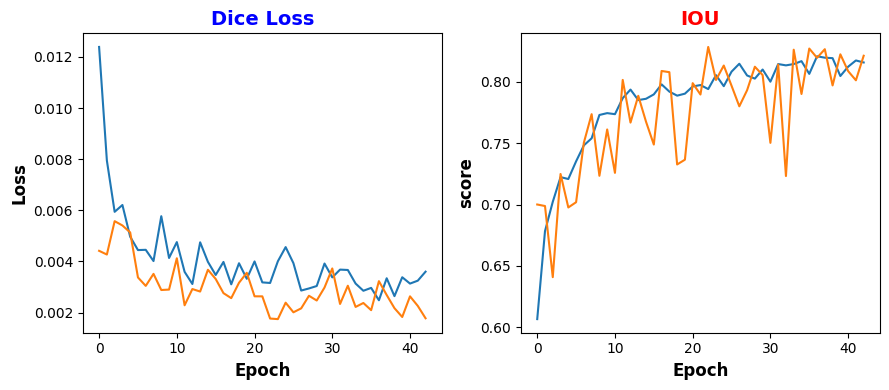

In [28]:
loss_and_metric_plot(RESULTS)

## Проверка модели

Определим функцию для предсказания на тестовых данных с использованием обученной модели.
    
    Args:
        test_dataloader: DataLoader с тестовыми данными
        best_model_path: путь к файлу с весами модели
    
    Returns:
        Предсказанные маски или вероятности

In [29]:
def predictions(test_dataloader:torch.utils.data.DataLoader, best_model:str):
    checkpoint = torch.load(best_model)
    loaded_model = smp.Unet(encoder_name = "resnet50", encoder_weights = None, classes = 8)
    loaded_model.load_state_dict(checkpoint)
    loaded_model.to(device = DEVICE)
    loaded_model.eval()

    pred_mask_test = []

    with torch.inference_mode():
        for X,_ in tqdm(test_dataloader):
            X = X.to(device = DEVICE, dtype = torch.float32)
            logit_mask = loaded_model(X)
            prob_mask = logit_mask.softmax(dim = 1)
            pred_mask = prob_mask.argmax(dim = 1)
            pred_mask_test.append(pred_mask.detach().cpu())

    pred_mask_test = torch.cat(pred_mask_test)

    return pred_mask_test

In [30]:
test_dataset = CustomDataset(data_test, color2id, image_transforms, mask_transforms)

test_dataloader = DataLoader(dataset = test_dataset, 
                             batch_size = BATCH_SIZE, 
                             shuffle = False)

Загружаем модель

In [31]:
pred_mask_test = predictions(test_dataloader, "best_model.pth")

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 8/8 [00:24<00:00,  3.06s/it]


Извлекаем данные из test_dataloader

In [32]:
IMAGE_TEST = []
MASK_TEST = []

for img,mask in test_dataloader:
    IMAGE_TEST.append(img)
    MASK_TEST.append(mask)

IMAGE_TEST = torch.cat(IMAGE_TEST)
MASK_TEST = torch.cat(MASK_TEST)

Расчет метрик теста

In [33]:
TP, FP, FN, TN = smp.metrics.get_stats(output = pred_mask_test.long(), 
                                       target = MASK_TEST.long(), 
                                       mode = "multiclass", 
                                       ignore_index = -1, 
                                       num_classes = 8)

In [34]:
iou_test = smp.metrics.iou_score(TP, FP, FN, TN, reduction = "micro")
f1_test = smp.metrics.f1_score(TP, FP, FN, TN, reduction="micro")
acc_test = smp.metrics.accuracy(TP, FP, FN, TN, reduction="micro")
prec_test = smp.metrics.precision(TP, FP, FN, TN, reduction="micro")
rec_test = smp.metrics.recall(TP, FP, FN, TN, reduction="micro")

print("МЕТРИКИ СЕГМЕНТАЦИИ")
print("═" * 40)
print(f"IoU Test: {iou_test:.4f}")
print(f"F1 Test: {f1_test:.4f}")
print(f"Accuracy Test: {acc_test:.4f}")
print(f"Precision Test: {prec_test:.4f}")
print(f"RecallTest: {rec_test:.4f}")

МЕТРИКИ СЕГМЕНТАЦИИ
════════════════════════════════════════
IoU Test: 0.7987
F1 Test: 0.8881
Accuracy Test: 0.9720
Precision Test: 0.8881
RecallTest: 0.8881


In [ ]:
id2color = {
    0:(0, 0, 0),       # background  
    1:(128, 0, 128),   # road
    2:(0, 128, 128),   # side
    3:(128, 0, 0),     # builds
    4:(0, 0, 128),     # plant
    5:(0, 128, 0),     # car
    6:(128, 128, 0),   # human
    7:(128,128,128)    # sign
}

In [ ]:
total_mask_output = []

for i,mask_pred in enumerate(pred_mask_test):
    height,width = mask_pred.shape
    mask_original = MASK_TEST[i]
    ignore = mask_original == -1 # id: -1
    
    mask_predicted = torch.where(ignore, -1, mask_pred)
    mask_zeros = torch.zeros(size = (height, width, 3), dtype = torch.uint8)
    
    for h in range(height):
        for w in range(width):
            idcolor = int(mask_predicted[h,w])
            
            if idcolor in id2color:
                mask_zeros[h,w,:] = torch.tensor(id2color[idcolor])
    
    total_mask_output.append(mask_zeros)

In [ ]:
total_mask_test = []

for mask_tst in MASK_TEST:
    height,width = mask_tst.shape
    mask_zeros = torch.zeros(size = (height, width, 3), dtype = torch.uint8)
    
    for h in range(height):
        for w in range(width):
            idcolor = int(mask_tst[h,w])
            
            if idcolor in id2color:
                mask_zeros[h,w,:] = torch.tensor(id2color[idcolor])
    
    total_mask_test.append(mask_zeros)

In [ ]:
fig, ax = plt.subplots(nrows = 2, ncols = 2, figsize = (8,12))

for i,(mk_out,mk_test) in enumerate(zip(total_mask_output, total_mask_test)):
    
    mask_test = mk_test.numpy()
    ax[i,0].imshow(mask_test)
    ax[i,0].set_title("Оригинальная маска", fontsize = 12, fontweight = "bold", color = "red")
    ax[i,0].axis('off')
    
    mask_out = mk_out.numpy()
    ax[i,1].imshow(mask_out)
    ax[i,1].set_title("Предсказанная маска", fontsize = 12, fontweight = "bold", color = "green")
    ax[i,1].axis('off')
    
fig.tight_layout()
fig.show()